In [1]:
import numpy as np
from numba import jit  # для ускорения вычислений
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [8]:
@jit(nopython=True)
def F1(v, τ, h_y, i1, i2, j, x, y):
    return (
        0.5 * τ / h_y**2 * (v[i1, i2 - 1, j - 1] + v[i1, i2 + 1, j - 1])
        + (1 - τ / h_y**2) * v[i1, i2, j - 1]
        + 0.5 * τ**2 * (j / 2) * np.sin(x[i1]) * np.cos(y[i2])
    )


@jit(nopython=True)
def F2(v, τ, h_x, i1, i2, j, x, y):
    return (
        0.5 * τ / h_x**2 * (v[i1 - 1, i2, j - 1] + v[i1 + 1, i2, j - 1])
        + (1 - τ / h_x**2) * v[i1, i2, j - 1]
        + 0.5 * τ**2 * ((j - 1) / 2) * np.sin(x[i1]) * np.cos(y[i2])
    )

In [11]:
@jit(nopython=True)
def tridiagonal_matrix_algorithm_x(
    v, τ, h_x, h_y, i2, j, x, y
):  # прогонка вдоль оси x
    N_x, N_y = int((X - X0) / h_x) + 1, int((Y - Y0) / h_y) + 1
    σ = np.empty(N_x)
    d = np.empty(N_x)
    σ[1] = 0  # начальные условия
    d[1] = 0  # начальные условия
    
    A_m = τ / (2 * h_x**2)
    B_m = τ / h_x**2 + 1
    C_m = τ / (2 * h_x**2)

    for m in range(1, N_x - 1):
        F_m = -F1(v, τ, h_y, m, i2, j, x, y)
        d[m + 1] = C_m / (B_m - A_m * d[m])
        σ[m + 1] = (F_m - A_m * σ[m]) / (A_m * d[m] - B_m)

    for m in range(N_x - 1, 0, -1):
        v[m - 1, i2, j] = d[m] * v[m, i2, j] + σ[m]

    return v


@jit(nopython=True)
def tridiagonal_matrix_algorithm_y(
    v, τ, h_x, h_y, i1, j, x, y
):  # прогонка вдоль оси y
    N_x, N_y = int((X - X0) / h_x) + 1, int((Y - Y0) / h_y) + 1
    σ = np.empty(N_y)
    d = np.empty(N_y)
    σ[1] = 0  # начальные условия
    d[1] = 1  # начальное условие по y
    
    A_m = τ / (2 * h_y**2)
    B_m = τ / h_y**2 + 1
    C_m = τ / (2 * h_y**2)

    for m in range(1, N_y - 1):
        F_m = -F2(v, τ, h_x, i1, m, j, x, y)
        d[m + 1] = C_m / (B_m - A_m * d[m])
        σ[m + 1] = (F_m - A_m * σ[m]) / (A_m * d[m] - B_m)
    v[i1, N_y - 1, j] = σ[-1] / (1 - d[-1])
    v[i1, N_y - 2, j] = v[i1, N_y - 1, j]

    for m in range(N_y - 2, 0, -1):
        v[i1, m - 1, j] = d[m] * v[i1, m, j] + σ[m]
    return v

In [27]:
def solution(x, y, t):
    return 0.25 * (np.exp(-2 * t) + 2 * t - 1) * np.sin(x) * np.cos(y)


def sol_array(hx, hy, ht):
    Nx, Ny, M = int((X - X0) / hx) + 1, int((Y - Y0) / hy) + 1, int(T / ht) + 1
    s = np.zeros((Nx, Ny, M), float)
    for i in range(0, Nx):
        for j in range(0, Ny):
            for k in range(0, M):
                s[i, j, k] = solution(i * hx, j * hy, k * ht)
    return s

In [23]:
def solution(x, y, t):
    return 0.25 * (np.exp(-2 * t) + 2 * t - 1) * np.sin(x) * np.cos(y)


@jit(nopython=True)
def sol_array(hx, hy, ht):
    Nx, Ny, M = int((X - X0) / hx) + 1, int((Y - Y0) / hy) + 1, int(T / ht) + 1
    s = np.empty((Nx, Ny, M), np.float64)
    for i in range(0, Nx):
        for j in range(0, Ny):
            for k in range(0, M):
                s[i, j, k] = solution(i * hx, j * hy, k * ht)
    return s

In [20]:
h_x, h_y, τ = 0.04, 0.04, 0.04  # шаг сетки
X0, X = 0, np.pi  # рссматриваемая область по x
Y0, Y = 0, np.pi  # рассматриваемая область по y
T = 2  # временной промежуток
N_x, N_y, M = (
    int((X - X0) / h_x) + 1,
    int((Y - Y0) / h_y) + 1,
    int(T / τ) + 1,
)  # количество шагов по x, y и t
Time = 2

u = np.zeros((N_x, N_y, 2 * M - 1), np.float64)  # массив для решения задачи
x, y = np.linspace(X0, X, N_x, dtype=np.float64), np.linspace(
    Y0, Y, N_y, dtype=np.float64
)  # сетка по x и y
t = np.linspace(0, T, M, dtype=np.float64)  # сетка по времени

In [22]:
#  запуск вычисления задачи
u = Solve(u, τ, h_x, h_y, x, y)

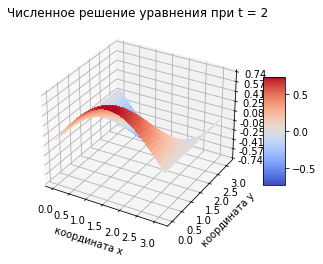

In [24]:
# 3D график
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
xx, yy = np.meshgrid(x, y)
surf = ax.plot_surface(
    xx,
    yy,
    np.transpose(u[:, :, 2 * (int(Time / τ) + 1) - 2]),
    cmap=cm.coolwarm,
    linewidth=0,
    antialiased=False,
)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter("{x:.02f}")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title(f"Численное решение уравнения при t = {Time}")
ax.set_xlabel("координата x")
ax.set_ylabel("координата y")
ax.set_zlabel("u")
plt.show()

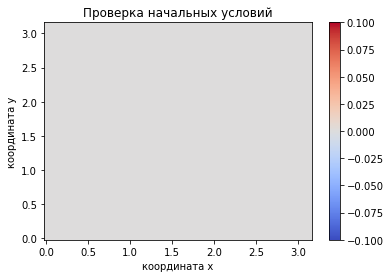

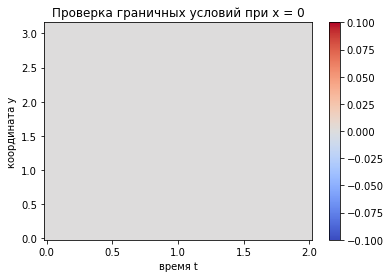

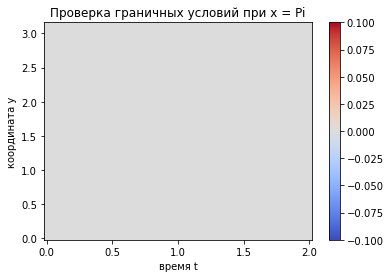

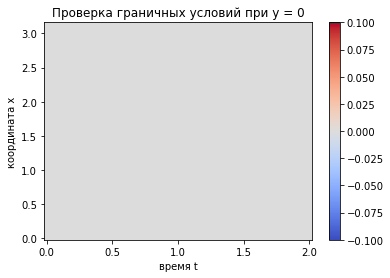

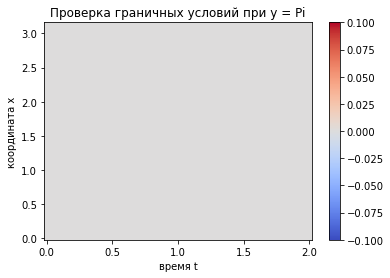

In [25]:
# проверка начальных условий
fig1, ax1 = plt.subplots()
cf = ax1.pcolormesh(
    x, y, np.transpose(u[:, :, 0]), cmap="coolwarm", shading="auto"
)
fig1.colorbar(cf, ax=ax1)

ax1.set_xlabel("координата x")
ax1.set_ylabel("координата y")
ax1.set_title("Проверка начальных условий")

# проверка граничных условий (x=0)
fig2, ax2 = plt.subplots()
cf = ax2.pcolormesh(t, y, u[0, :, ::2], cmap="coolwarm", shading="auto")
fig2.colorbar(cf, ax=ax2)

ax2.set_xlabel("время t")
ax2.set_ylabel("координата y")
ax2.set_title("Проверка граничных условий при x = 0")

# (x=Pi)
fig3, ax3 = plt.subplots()
cf = ax3.pcolormesh(t, y, u[N_x - 1, :, ::2], cmap="coolwarm", shading="auto")
fig3.colorbar(cf, ax=ax3)

ax3.set_xlabel("время t")
ax3.set_ylabel("координата y")
ax3.set_title("Проверка граничных условий при x = Pi")

# (y=0)
fig4, ax4 = plt.subplots()
cf = ax4.pcolormesh(
    t, x, (u[:, 1, ::2] - u[:, 0, ::2]) / h_y, cmap="coolwarm", shading="auto"
)
fig4.colorbar(cf, ax=ax4)

ax4.set_xlabel("время t")
ax4.set_ylabel("координата x")
ax4.set_title("Проверка граничных условий при y = 0")

# (y=Pi)
fig5, ax5 = plt.subplots()
cf = ax5.pcolormesh(
    t,
    x,
    (u[:, N_y - 1, ::2] - u[:, N_y - 2, ::2]) / h_y,
    cmap="coolwarm",
    shading="auto",
)
fig5.colorbar(cf, ax=ax5)

ax5.set_xlabel("время t")
ax5.set_ylabel("координата x")
ax5.set_title("Проверка граничных условий при y = Pi")

plt.show()

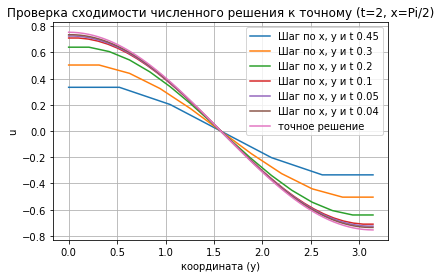

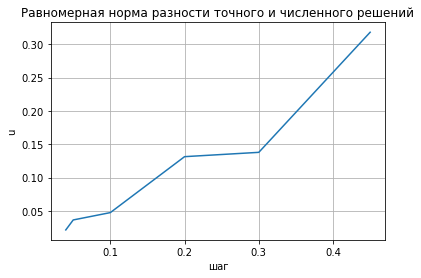

In [28]:
# сравнение точного решения с численным
fig3, ax3 = plt.subplots()
fig4, ax4 = plt.subplots()
ht = [0.45, 0.3, 0.2, 0.1, 0.05]  # шаги по координатам
i = 0
Max = np.zeros(6)
for step in ht:
    NN_x, NN_y, MM = (
        int((X - X0) / step) + 1,
        int((Y - Y0) / step) + 1,
        int(T / step) + 1,
    )
    uu = np.zeros((NN_x, NN_y, 2 * MM - 1), float)  # массив для решения задачи
    xx, yy = np.linspace(X0, X, NN_x, dtype=float), np.linspace(
        Y0, Y, NN_y, dtype=float
    )  # сетка по x и y
    tt = np.linspace(0, T, MM, dtype=float)  # сетка по времени
    uu = Solve(uu, step, step, step, xx, yy)
    ax3.plot(
        yy,
        uu[int((NN_x - 1) / 2) + 1, :, 2 * MM - 2],
        label="Шаг по x, y и t " + str(step),
    )

    acc = sol_array(step, step, step)
    norma = abs(acc[:, :, :] - uu[:, :, ::2])
    Max[i] = np.max(norma)
    i += 1

acc = sol_array(h_x, h_y, τ)
norma = abs(acc[:, :, :] - u[:, :, ::2])
Max[i] = np.max(norma)
ht.append(τ)

ax4.plot(ht, Max)
ax3.plot(
    y,
    u[int((N_x - 1) / 2) + 1, :, 2 * M - 2],
    label="Шаг по x, y и t " + str(h_x),
)
ax3.plot(yy, solution(np.pi / 2, yy, T), label="точное решение")

ax3.set(
    xlabel="координата (y)",
    ylabel="u",
    title="Проверка сходимости численного решения к точному (t=2, x=Pi/2)",
)
ax3.grid()
ax3.legend()
ax4.set(
    xlabel="шаг",
    ylabel="u",
    title="Равномерная норма разности точного и численного решений",
)
ax4.grid()

plt.show()